# Presentación

https://docs.google.com/presentation/d/1Ov8pD2THupoy_R2V5Bs2ZsP3h5w0moYZvSTcIoKtFH4/edit?folder=0AK-QVmjH2qRwUk9PVA#slide=id.g6cb4ad294c_0_12

In [1]:
import gym
import numpy as np
from tensorboardX import SummaryWriter
from time import time

In [2]:
from pyvirtualdisplay import Display
display = Display(visible=0, size=(1024, 768))
display.start()
import os
os.environ["DISPLAY"] = ":" + str(display.display) + "." + str(display.screen)
import moviepy.editor as mpy

In [56]:
def save_video(writer, name):
    done = False
    frames = []
    discrete_state = get_discrete_state(env.reset())
    while not done:
        action = np.argmax(q_table[discrete_state])
        new_state, reward, done, _ = env.step(action)
        frames.append(env.render(mode = 'rgb_array'))
        discrete_state = get_discrete_state(new_state)
    frames = np.array(frames)
    video = np.array(frames).reshape((1, )+frames.shape)
    writer.add_video(name, np.rollaxis(video, 4, 2), fps=20)
    writer.flush()

In [57]:
def get_Q_table(env, q_table):
    plt.ioff()
    x = np.arange(env.observation_space.low[0], env.observation_space.high[0], discrete_os_win_size[0])
    y = np.arange(env.observation_space.low[1], env.observation_space.high[1], discrete_os_win_size[1])
    xx, yy = np.meshgrid(x, y, sparse=False)
    f = plt.figure()
    cs = plt.contourf(xx, yy, np.argmax(np.rollaxis(q_table, 1, 0), axis=2)/2, levels=[0, 0.33, 0.66, 1], cmap='gray')  #, vmin=0, vmax=2
    plt.xlabel('posición')
    plt.ylabel('velocidad')
    cbar = plt.colorbar()
    cbar.set_ticks(np.array([0, 1, 2])/2)
    cbar.set_ticklabels(['push left', 'no push', 'push right'])
    plt.close(f)
    plt.ion()
    return f

In [4]:
env = gym.make('MountainCar-v0')
# env = gym.make('CartPole-v1')

In [5]:
env.action_space

Discrete(3)

In [6]:
env.observation_space.high, env.observation_space.low

(array([0.6 , 0.07], dtype=float32), array([-1.2 , -0.07], dtype=float32))

In [7]:
DISCRETE_OS_SIZE = [50, 50]
discrete_os_win_size = (env.observation_space.high - env.observation_space.low)/DISCRETE_OS_SIZE
print(discrete_os_win_size)

[0.036  0.0028]


In [8]:
q_table = np.random.uniform(low=-2, high=0, size=(DISCRETE_OS_SIZE + [env.action_space.n]))

In [9]:
q_table.shape

(50, 50, 3)

In [10]:
import gym
import numpy as np

env = gym.make("MountainCar-v0")
env.reset()

discrete_os_win_size = (env.observation_space.high - env.observation_space.low)/DISCRETE_OS_SIZE


In [69]:
# Q-Learning settings

EPISODES = 25000

In [70]:
def get_discrete_state(state):
    discrete_state = (state - env.observation_space.low)/discrete_os_win_size
    return tuple(discrete_state.astype(np.int))

In [74]:
# q_table = np.random.uniform(low=-2, high=0, size=(DISCRETE_OS_SIZE + [env.action_space.n]))
# q_table = np.zeros((DISCRETE_OS_SIZE + [env.action_space.n]))
LEARNING_RATE = 0.05
DISCOUNT = 0.99
epsilon = 0.01 #0.5 #1
START_EPSILON_DECAYING = 0.2
END_EPSILON_DECAYING = EPISODES # //8
epsilon_decay_value = epsilon/(END_EPSILON_DECAYING - START_EPSILON_DECAYING)
ep_return = 0
steps = 0
start_time = int(time())
writer = SummaryWriter(f'logs/table/{start_time}/{LEARNING_RATE}_{DISCOUNT}')

best_return = -np.infty

save_video(writer, f'{start_time}/0_{-201}/render')
writer.add_figure(f'{start_time}/0_{-201}/qtable', get_Q_table(env, q_table))

for episode in range(EPISODES):
    discrete_state = get_discrete_state(env.reset())
    done = False
    
    print(f'\r{episode}', end='')
    
    while not done:

        if np.random.random() > epsilon:
            # Get action from Q table
            action = np.argmax(q_table[discrete_state])
        else:
            # Get random action
            action = np.random.randint(0, env.action_space.n)


        new_state, reward, done, _ = env.step(action)
        ep_return += reward
        steps += 1

        new_discrete_state = get_discrete_state(new_state)

        # If simulation did not end yet after last step - update Q table
        if not done:

            # Maximum possible Q value in next step (for new state)
            max_future_q = np.max(q_table[new_discrete_state])

            # Current Q value (for current state and performed action)
            current_q = q_table[discrete_state + (action,)]

            # And here's our equation for a new Q value for current state and action
            new_q = (1 - LEARNING_RATE) * current_q + LEARNING_RATE * (reward + DISCOUNT * max_future_q)

            # Update Q table with new Q value
            q_table[discrete_state + (action,)] = new_q


        # Simulation ended (for any reason) - if goal position is achived - update Q value with reward directly
        else:
            if new_state[0] >= env.goal_position:
                #q_table[discrete_state + (action,)] = reward
                q_table[discrete_state + (action,)] = 0
            
            if ep_return>=best_return:
                save_video(writer, f'{start_time}/{episode+1}_{ep_return}/render')
                writer.add_figure(f'{start_time}/{episode+1}_{ep_return}/qtable', get_Q_table(env, q_table))
                best_return = ep_return
                # Hack para que no muestra tantas imagenes cuando empieza
                if ep_return <= -200.0:
                    best_return = -199.0
                
            writer.add_scalar('return', ep_return, episode+1)
            writer.add_scalar('step', steps, episode+1)
            writer.add_scalar('epsilon', epsilon, episode+1)
            
            ep_return = 0
            steps = 0

        discrete_state = new_discrete_state

    # Decaying is being done every episode if episode number is within decaying range
    if END_EPSILON_DECAYING >= episode >= START_EPSILON_DECAYING:
        epsilon -= epsilon_decay_value


env.close()

t:  12%|█▏        | 14/116 [00:00<00:00, 130.81it/s, now=None]

MoviePy - Building file /tmp/tmpuvlbe89u.gif with imageio.


0

t:  11%|█         | 14/133 [00:00<00:00, 131.82it/s, now=None]

MoviePy - Building file /tmp/tmp16ilexc8.gif with imageio.


1

t:  12%|█▏        | 14/118 [00:00<00:00, 133.63it/s, now=None]

MoviePy - Building file /tmp/tmp8j86unca.gif with imageio.


12

t:  13%|█▎        | 14/110 [00:00<00:00, 131.41it/s, now=None]

MoviePy - Building file /tmp/tmpyvv3eqvj.gif with imageio.


18

t:  10%|█         | 14/139 [00:00<00:00, 130.94it/s, now=None]

MoviePy - Building file /tmp/tmpok6f9jhz.gif with imageio.


35

t:  10%|█         | 14/137 [00:00<00:00, 130.44it/s, now=None]

MoviePy - Building file /tmp/tmp7u001jcr.gif with imageio.


38

t:  13%|█▎        | 14/108 [00:00<00:00, 130.72it/s, now=None]

MoviePy - Building file /tmp/tmp_ovorm62.gif with imageio.


107

t:  10%|█         | 14/139 [00:00<00:00, 129.97it/s, now=None]

MoviePy - Building file /tmp/tmp1h8t85ac.gif with imageio.


184

t:  11%|█         | 14/133 [00:00<00:00, 131.85it/s, now=None]

MoviePy - Building file /tmp/tmpgy9kccds.gif with imageio.


1517

t:  12%|█▏        | 14/116 [00:00<00:00, 133.22it/s, now=None]

MoviePy - Building file /tmp/tmplkl30wdd.gif with imageio.


1621

t:  10%|█         | 14/134 [00:00<00:00, 132.51it/s, now=None]

MoviePy - Building file /tmp/tmpkgvt52t9.gif with imageio.


1865

t:  10%|█         | 14/137 [00:00<00:00, 132.97it/s, now=None]

MoviePy - Building file /tmp/tmp045xl3kv.gif with imageio.


2246

t:  10%|█         | 14/134 [00:00<00:00, 134.55it/s, now=None]

MoviePy - Building file /tmp/tmpbcedix5k.gif with imageio.


2746

t:  10%|▉         | 13/134 [00:00<00:00, 128.44it/s, now=None]

MoviePy - Building file /tmp/tmpc95dkden.gif with imageio.


2784

t:   9%|▉         | 12/136 [00:00<00:01, 118.45it/s, now=None]

MoviePy - Building file /tmp/tmp9xqwc4el.gif with imageio.


24999

In [22]:
# normailized_q_table = (q_table - q_table.min())
# normailized_q_table = normailized_q_table/normailized_q_table.max()

In [23]:
# from matplotlib import pyplot as plt
# plt.imshow(normailized_q_table)

In [24]:
# normailized_q_table.max(), normailized_q_table.min()

In [33]:
# plt.imshow(np.argmax(q_table, axis=2)[::-1], cmap='gray')
from matplotlib import pyplot as plt

In [55]:
def get_Q_table(env, q_table):
    plt.ioff()
    x = np.arange(env.observation_space.low[0], env.observation_space.high[0], discrete_os_win_size[0])
    y = np.arange(env.observation_space.low[1], env.observation_space.high[1], discrete_os_win_size[1])
    xx, yy = np.meshgrid(x, y, sparse=False)
    f = plt.figure()
    cs = plt.contourf(xx, yy, np.argmax(np.rollaxis(q_table, 1, 0), axis=2)/2, levels=[0, 0.33, 0.66, 1], cmap='gray')  #, vmin=0, vmax=2
    plt.xlabel('posición')
    plt.ylabel('velocidad')
    cbar = plt.colorbar()
    cbar.set_ticks(np.array([0, 1, 2])/2)
    cbar.set_ticklabels(['push left', 'no push', 'push right'])
    plt.close(f)
    plt.ion()
    return f

In [53]:
f = get_Q_table()

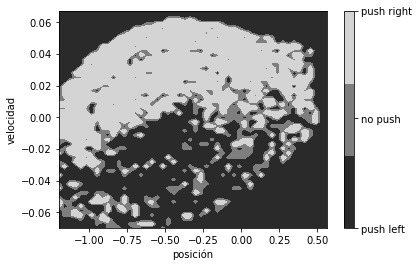

In [54]:
f